In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

In [ ]:
# Load dataset
data = tfds.load("imagenette/320px", split="train", as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px/incomplete.D5GN4F_1.0.0/imagenette-train.tfrecord*...:   …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px/incomplete.D5GN4F_1.0.0/imagenette-validation.tfrecord*..…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/320px/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess(img, label):
    img = tf.image.resize(img, (64, 64))
    img = tf.cast(img, tf.float32) / 255.0
    img_gray = tf.image.rgb_to_grayscale(img)
    return img_gray, img

data = data.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Attention block with resizing
from tensorflow.keras.layers import Lambda

In [ ]:
def attention_block(x, g, inter_channels, resize_shape):
    theta = layers.Conv2D(inter_channels, 1, padding='same')(x)
    phi = layers.Conv2D(inter_channels, 1, padding='same')(g)
    phi = tf.keras.layers.Resizing(resize_shape[0], resize_shape[1], interpolation='bilinear')(phi)
    attn = layers.Activation('relu')(layers.Add()([theta, phi]))
    attn = layers.Conv2D(1, 1, activation='sigmoid')(attn)
    out = layers.Multiply()([x, attn])
    return out

In [ ]:
# U-Net-like Generator with attention
def build_generator(input_shape=(64, 64, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x1_pool = layers.MaxPooling2D((2, 2))(x1)  # 32x32

    x2 = layers.Conv2D(128, 3, activation='relu', padding='same')(x1_pool)
    x2_pool = layers.MaxPooling2D((2, 2))(x2)  # 16x16

    x3 = layers.Conv2D(256, 3, activation='relu', padding='same')(x2_pool)
    x3_pool = layers.MaxPooling2D((2, 2))(x3)  # 8x8

    # Bottleneck
    x4 = layers.Conv2D(512, 3, activation='relu', padding='same')(x3_pool)

    # Decoder
    u3 = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x4)  # 16x16
    att3 = attention_block(x3, u3, 128, resize_shape=(16, 16))
    u3 = layers.Concatenate()([u3, att3])

    u2 = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(u3)  # 32x32
    att2 = attention_block(x2, u2, 64, resize_shape=(32, 32))
    u2 = layers.Concatenate()([u2, att2])

    u1 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(u2)  # 64x64
    att1 = attention_block(x1, u1, 32, resize_shape=(64, 64))
    u1 = layers.Concatenate()([u1, att1])

    outputs = layers.Conv2D(3, 1, activation='sigmoid', padding='same')(u1)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# Simple Discriminator
def build_discriminator(input_shape=(64, 64, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, x)

In [ ]:
# === Load VGG for perceptual loss ===
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
vgg.trainable = False
perceptual_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
generator = build_generator()
discriminator = build_discriminator()

loss_fn = tf.keras.losses.BinaryCrossentropy()
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

Epoch 1/200
Generator Loss: 58.3915, Discriminator Loss: 1.0810, PSNR: 12.74, SSIM: 0.2166
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


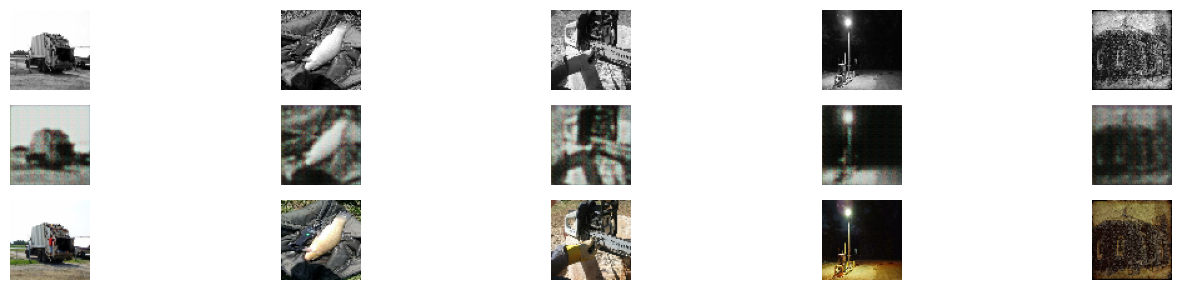

Epoch 2/200
Generator Loss: 32.8700, Discriminator Loss: 1.1476, PSNR: 17.58, SSIM: 0.5789
Epoch 3/200
Generator Loss: 28.7592, Discriminator Loss: 1.0492, PSNR: 18.38, SSIM: 0.6455
Epoch 4/200
Generator Loss: 26.5264, Discriminator Loss: 1.0092, PSNR: 19.11, SSIM: 0.7057
Epoch 5/200
Generator Loss: 24.9727, Discriminator Loss: 1.0607, PSNR: 19.62, SSIM: 0.7374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


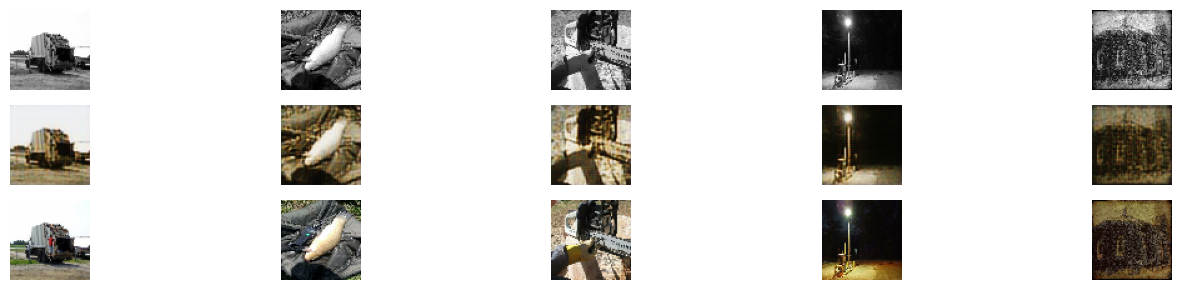

Epoch 6/200
Generator Loss: 23.9625, Discriminator Loss: 1.0693, PSNR: 19.85, SSIM: 0.7589
Epoch 7/200
Generator Loss: 23.1866, Discriminator Loss: 1.0437, PSNR: 20.18, SSIM: 0.7780
Epoch 8/200
Generator Loss: 22.7881, Discriminator Loss: 1.0431, PSNR: 20.31, SSIM: 0.7904
Epoch 9/200
Generator Loss: 22.5021, Discriminator Loss: 1.0502, PSNR: 20.45, SSIM: 0.7961
Epoch 10/200
Generator Loss: 22.1218, Discriminator Loss: 1.0000, PSNR: 20.64, SSIM: 0.8063
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


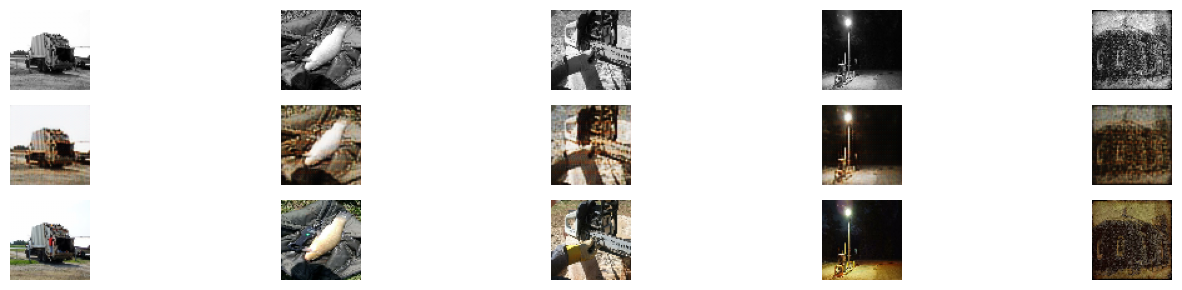

Epoch 11/200
Generator Loss: 22.0427, Discriminator Loss: 1.0604, PSNR: 20.64, SSIM: 0.8019
Epoch 12/200
Generator Loss: 21.7248, Discriminator Loss: 1.0145, PSNR: 20.91, SSIM: 0.8235
Epoch 13/200
Generator Loss: 21.3883, Discriminator Loss: 1.1143, PSNR: 21.06, SSIM: 0.8290
Epoch 14/200
Generator Loss: 21.2608, Discriminator Loss: 0.9953, PSNR: 21.19, SSIM: 0.8361
Epoch 15/200
Generator Loss: 21.0964, Discriminator Loss: 1.0250, PSNR: 21.21, SSIM: 0.8341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


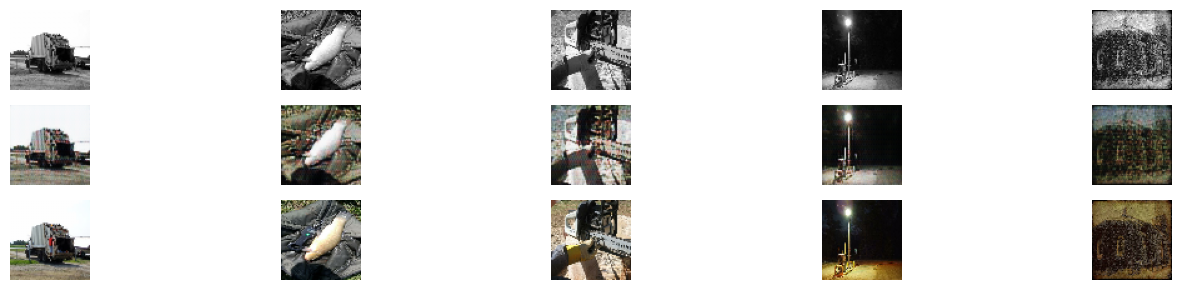

Epoch 16/200
Generator Loss: 21.0054, Discriminator Loss: 1.0166, PSNR: 21.34, SSIM: 0.8460
Epoch 17/200
Generator Loss: 20.8383, Discriminator Loss: 0.9912, PSNR: 21.39, SSIM: 0.8415
Epoch 18/200
Generator Loss: 20.7700, Discriminator Loss: 0.9797, PSNR: 21.59, SSIM: 0.8548
Epoch 19/200
Generator Loss: 20.6324, Discriminator Loss: 1.0567, PSNR: 21.55, SSIM: 0.8515
Epoch 20/200
Generator Loss: 20.4646, Discriminator Loss: 0.9830, PSNR: 21.78, SSIM: 0.8660
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


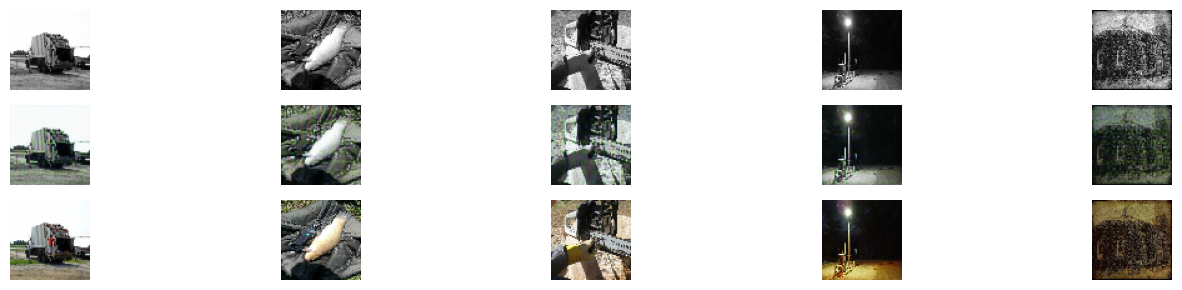

Epoch 21/200
Generator Loss: 20.4735, Discriminator Loss: 0.9869, PSNR: 21.65, SSIM: 0.8518
Epoch 22/200
Generator Loss: 20.3870, Discriminator Loss: 0.9711, PSNR: 21.86, SSIM: 0.8671
Epoch 23/200
Generator Loss: 20.2796, Discriminator Loss: 0.9482, PSNR: 21.98, SSIM: 0.8700
Epoch 24/200
Generator Loss: 20.1223, Discriminator Loss: 0.9529, PSNR: 22.12, SSIM: 0.8758
Epoch 25/200
Generator Loss: 20.0375, Discriminator Loss: 0.9723, PSNR: 22.12, SSIM: 0.8764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


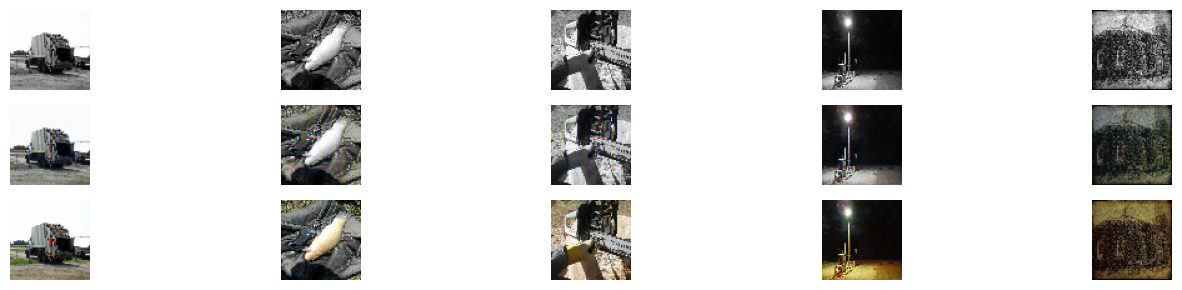

Epoch 26/200
Generator Loss: 20.0195, Discriminator Loss: 1.0131, PSNR: 22.14, SSIM: 0.8752
Epoch 27/200
Generator Loss: 19.8163, Discriminator Loss: 0.9502, PSNR: 22.44, SSIM: 0.8891
Epoch 28/200
Generator Loss: 19.7478, Discriminator Loss: 0.9610, PSNR: 22.46, SSIM: 0.8864
Epoch 29/200
Generator Loss: 19.6895, Discriminator Loss: 0.9476, PSNR: 22.62, SSIM: 0.8940
Epoch 30/200
Generator Loss: 19.5733, Discriminator Loss: 0.9794, PSNR: 22.62, SSIM: 0.8939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


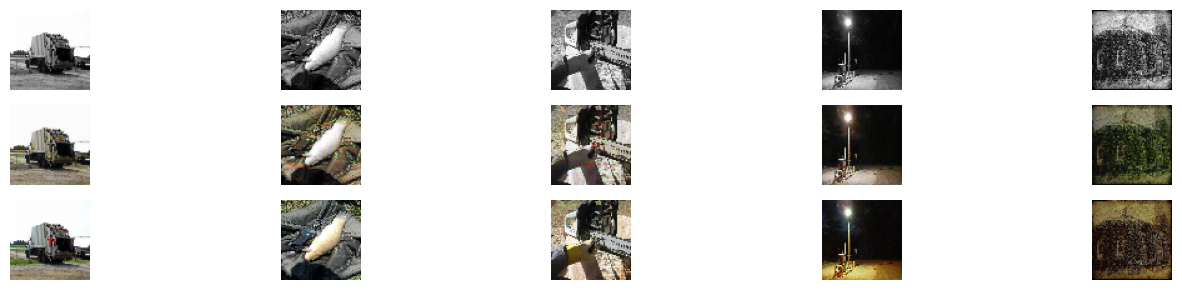

Epoch 31/200
Generator Loss: 19.4438, Discriminator Loss: 0.9646, PSNR: 22.77, SSIM: 0.8985
Epoch 32/200
Generator Loss: 19.3473, Discriminator Loss: 0.9793, PSNR: 22.82, SSIM: 0.8994
Epoch 33/200
Generator Loss: 19.2162, Discriminator Loss: 0.9758, PSNR: 22.92, SSIM: 0.9020
Epoch 34/200
Generator Loss: 19.1329, Discriminator Loss: 0.9768, PSNR: 22.96, SSIM: 0.9027
Epoch 35/200
Generator Loss: 19.0893, Discriminator Loss: 0.9834, PSNR: 22.98, SSIM: 0.9034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


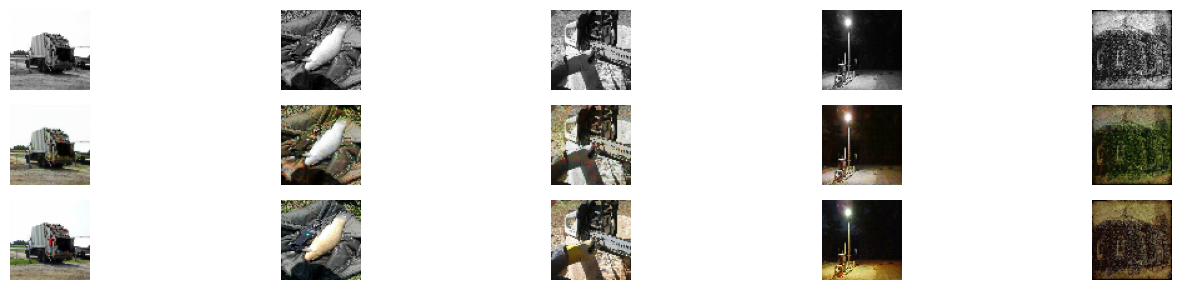

Epoch 36/200
Generator Loss: 18.9933, Discriminator Loss: 0.9810, PSNR: 23.03, SSIM: 0.9040
Epoch 37/200
Generator Loss: 18.9951, Discriminator Loss: 0.9832, PSNR: 23.05, SSIM: 0.9045
Epoch 38/200
Generator Loss: 18.9515, Discriminator Loss: 0.9766, PSNR: 23.08, SSIM: 0.9050
Epoch 39/200
Generator Loss: 18.8628, Discriminator Loss: 1.0048, PSNR: 23.12, SSIM: 0.9068
Epoch 40/200
Generator Loss: 18.7855, Discriminator Loss: 0.9782, PSNR: 23.15, SSIM: 0.9065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


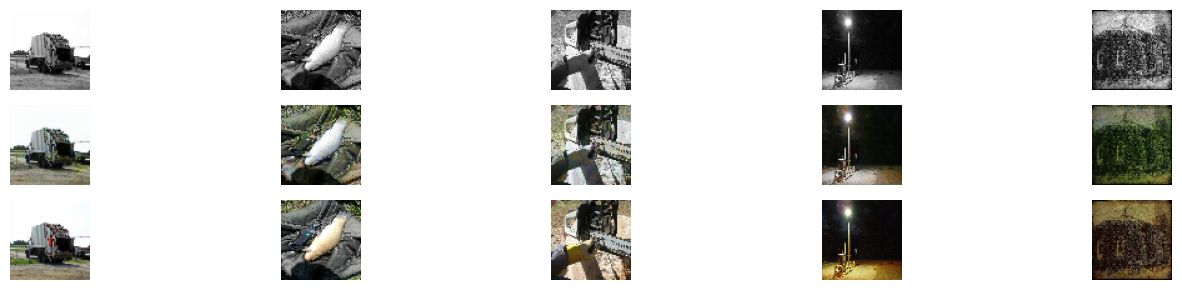

Epoch 41/200
Generator Loss: 18.7256, Discriminator Loss: 0.9864, PSNR: 23.17, SSIM: 0.9071
Epoch 42/200
Generator Loss: 18.6839, Discriminator Loss: 0.9961, PSNR: 23.17, SSIM: 0.9074
Epoch 43/200
Generator Loss: 18.6096, Discriminator Loss: 1.0080, PSNR: 23.20, SSIM: 0.9079
Epoch 44/200
Generator Loss: 18.5421, Discriminator Loss: 0.9816, PSNR: 23.23, SSIM: 0.9080
Epoch 45/200
Generator Loss: 18.4761, Discriminator Loss: 0.9856, PSNR: 23.26, SSIM: 0.9083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


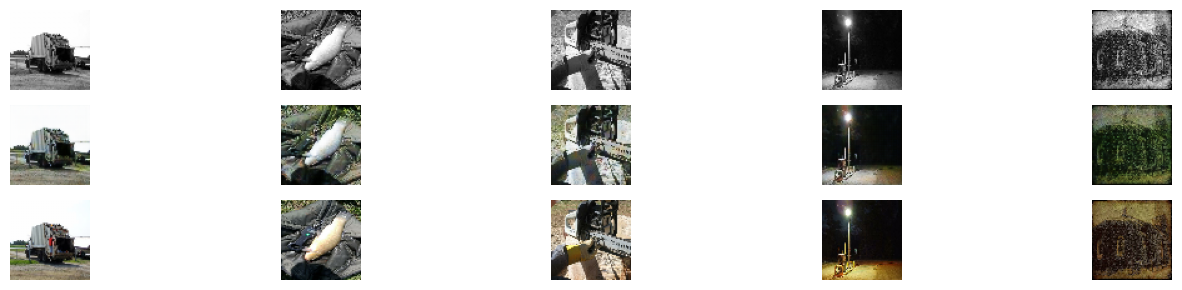

Epoch 46/200
Generator Loss: 18.3815, Discriminator Loss: 1.0011, PSNR: 23.28, SSIM: 0.9086
Epoch 47/200
Generator Loss: 18.3509, Discriminator Loss: 0.9860, PSNR: 23.28, SSIM: 0.9085
Epoch 48/200
Generator Loss: 18.2641, Discriminator Loss: 0.9980, PSNR: 23.33, SSIM: 0.9087
Epoch 49/200
Generator Loss: 18.2763, Discriminator Loss: 0.9966, PSNR: 23.30, SSIM: 0.9084
Epoch 50/200
Generator Loss: 18.1328, Discriminator Loss: 1.0034, PSNR: 23.41, SSIM: 0.9095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


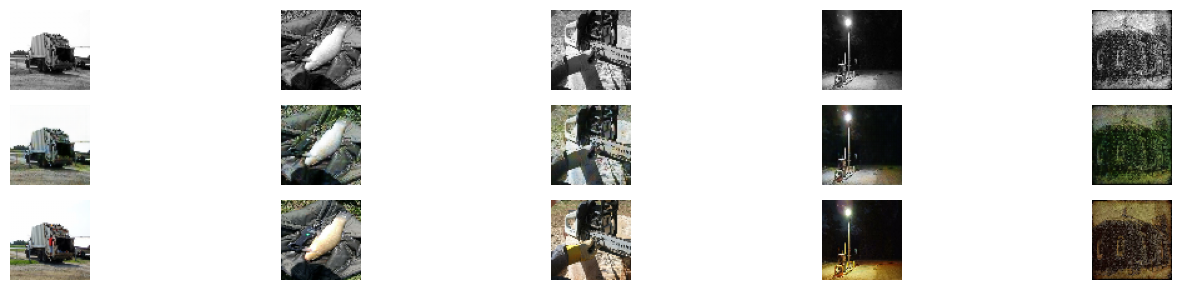

Epoch 51/200
Generator Loss: 18.0781, Discriminator Loss: 0.9891, PSNR: 23.40, SSIM: 0.9095
Epoch 52/200
Generator Loss: 18.0162, Discriminator Loss: 0.9945, PSNR: 23.42, SSIM: 0.9097
Epoch 53/200
Generator Loss: 17.9505, Discriminator Loss: 0.9858, PSNR: 23.47, SSIM: 0.9105
Epoch 54/200
Generator Loss: 17.8621, Discriminator Loss: 0.9894, PSNR: 23.48, SSIM: 0.9103
Epoch 55/200
Generator Loss: 17.8061, Discriminator Loss: 1.0054, PSNR: 23.49, SSIM: 0.9105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


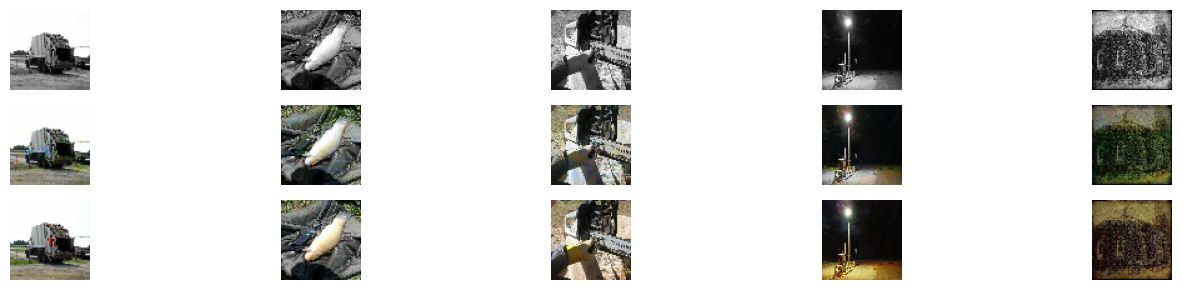

Epoch 56/200
Generator Loss: 17.7970, Discriminator Loss: 0.9756, PSNR: 23.52, SSIM: 0.9108
Epoch 57/200
Generator Loss: 17.7157, Discriminator Loss: 0.9905, PSNR: 23.53, SSIM: 0.9106
Epoch 58/200
Generator Loss: 17.7317, Discriminator Loss: 0.9869, PSNR: 23.52, SSIM: 0.9106
Epoch 59/200
Generator Loss: 17.6568, Discriminator Loss: 1.0106, PSNR: 23.55, SSIM: 0.9111
Epoch 60/200
Generator Loss: 17.6686, Discriminator Loss: 0.9843, PSNR: 23.55, SSIM: 0.9108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


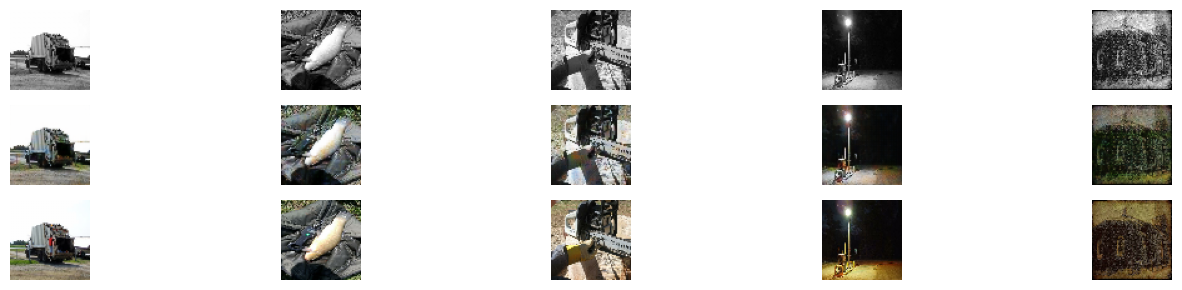

Epoch 61/200
Generator Loss: 17.6480, Discriminator Loss: 0.9794, PSNR: 23.57, SSIM: 0.9111
Epoch 62/200
Generator Loss: 17.6388, Discriminator Loss: 0.9836, PSNR: 23.56, SSIM: 0.9112
Epoch 63/200
Generator Loss: 17.5479, Discriminator Loss: 0.9665, PSNR: 23.61, SSIM: 0.9116
Epoch 64/200
Generator Loss: 17.5180, Discriminator Loss: 0.9856, PSNR: 23.62, SSIM: 0.9119
Epoch 65/200
Generator Loss: 17.4825, Discriminator Loss: 0.9600, PSNR: 23.65, SSIM: 0.9117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


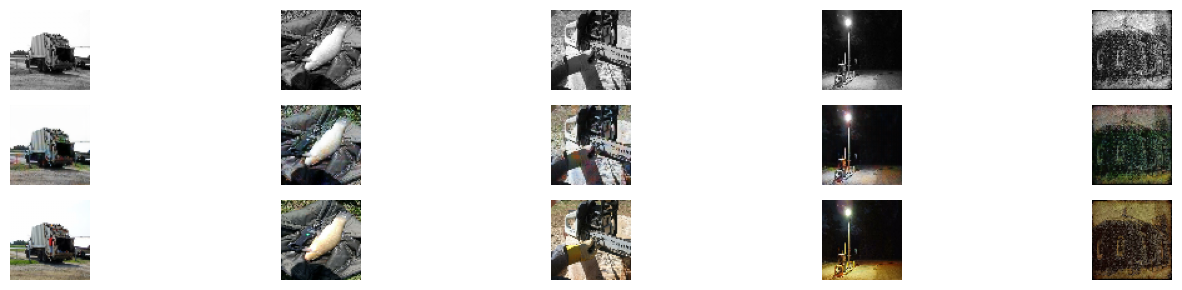

Epoch 66/200
Generator Loss: 17.4981, Discriminator Loss: 0.9932, PSNR: 23.60, SSIM: 0.9111
Epoch 67/200
Generator Loss: 17.4265, Discriminator Loss: 0.9840, PSNR: 23.65, SSIM: 0.9118
Epoch 68/200
Generator Loss: 17.3155, Discriminator Loss: 0.9610, PSNR: 23.70, SSIM: 0.9121
Epoch 69/200
Generator Loss: 17.3471, Discriminator Loss: 0.9771, PSNR: 23.68, SSIM: 0.9120
Epoch 70/200
Generator Loss: 17.3538, Discriminator Loss: 0.9802, PSNR: 23.68, SSIM: 0.9119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


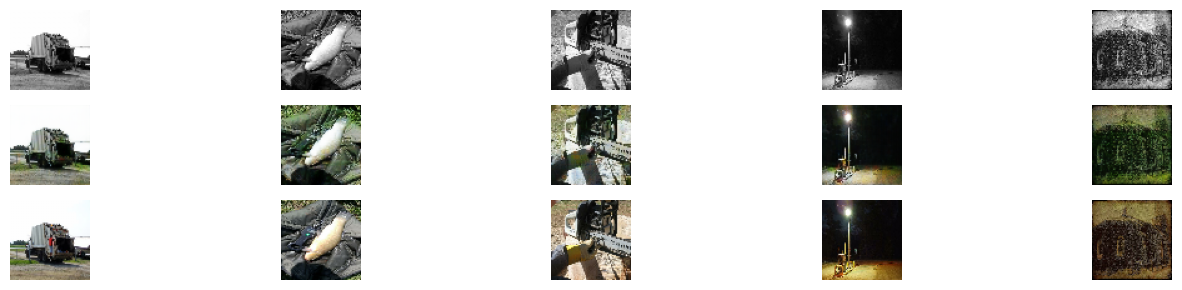

Epoch 71/200
Generator Loss: 17.2793, Discriminator Loss: 0.9570, PSNR: 23.72, SSIM: 0.9126
Epoch 72/200
Generator Loss: 17.1910, Discriminator Loss: 0.9629, PSNR: 23.75, SSIM: 0.9125
Epoch 73/200
Generator Loss: 17.1065, Discriminator Loss: 0.9703, PSNR: 23.77, SSIM: 0.9124
Epoch 74/200
Generator Loss: 17.0526, Discriminator Loss: 0.9628, PSNR: 23.79, SSIM: 0.9127
Epoch 75/200
Generator Loss: 17.0278, Discriminator Loss: 0.9755, PSNR: 23.78, SSIM: 0.9122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


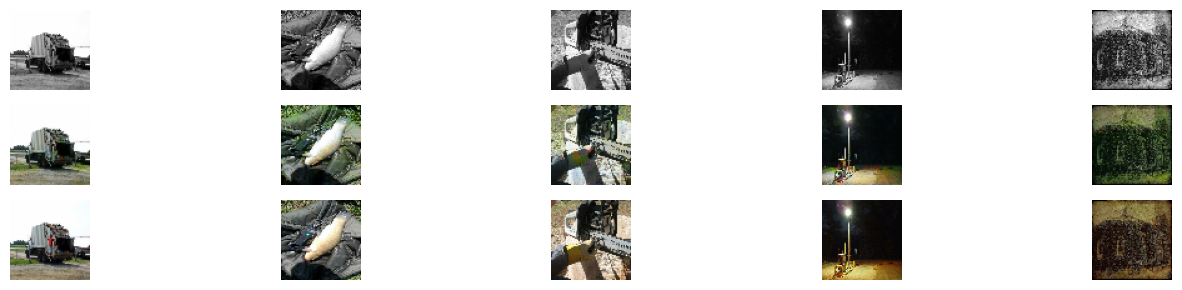

Epoch 76/200
Generator Loss: 17.0294, Discriminator Loss: 0.9490, PSNR: 23.80, SSIM: 0.9125
Epoch 77/200
Generator Loss: 17.0367, Discriminator Loss: 0.9645, PSNR: 23.79, SSIM: 0.9123
Epoch 78/200
Generator Loss: 17.1062, Discriminator Loss: 0.9432, PSNR: 23.78, SSIM: 0.9124
Epoch 79/200
Generator Loss: 17.1202, Discriminator Loss: 0.9640, PSNR: 23.76, SSIM: 0.9121
Epoch 80/200
Generator Loss: 17.0430, Discriminator Loss: 0.9605, PSNR: 23.78, SSIM: 0.9122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


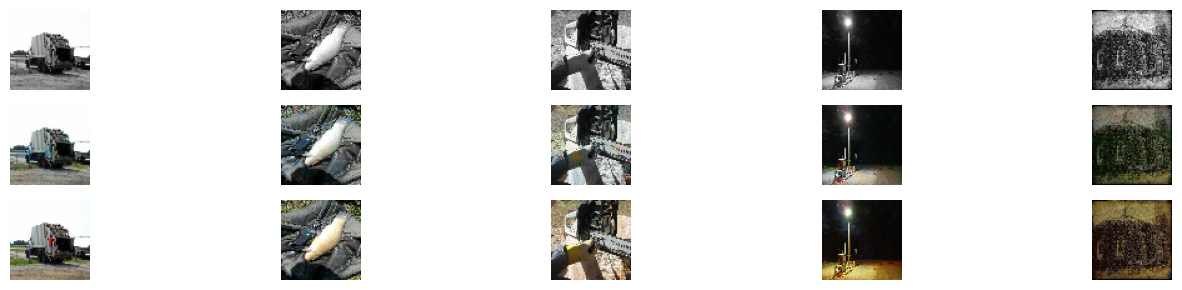

Epoch 81/200
Generator Loss: 16.8609, Discriminator Loss: 0.9616, PSNR: 23.87, SSIM: 0.9127
Epoch 82/200
Generator Loss: 16.8504, Discriminator Loss: 0.9533, PSNR: 23.83, SSIM: 0.9121
Epoch 83/200
Generator Loss: 16.8106, Discriminator Loss: 0.9547, PSNR: 23.86, SSIM: 0.9123
Epoch 84/200


In [ ]:
# === Training with early stopping ===
EPOCHS = 200
best_psnr = 0
patience = 7
wait = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    epoch_gen_loss, epoch_disc_loss = 0, 0
    all_psnr, all_ssim = [], []
    total_batches = 0

    for x_gray, x_real in data:
        total_batches += 1

        # Train Discriminator
        with tf.GradientTape() as tape:
            x_fake = generator(x_gray, training=True)
            real_logits = discriminator(x_real, training=True)
            fake_logits = discriminator(x_fake, training=True)
            disc_loss = loss_fn(tf.ones_like(real_logits) * 0.9, real_logits) + \
                        loss_fn(tf.zeros_like(fake_logits), fake_logits)
        grads = tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as tape:
            x_fake = generator(x_gray, training=True)
            fake_logits = discriminator(x_fake, training=True)
            gan_loss = loss_fn(tf.ones_like(fake_logits), fake_logits)
            l1_loss = tf.reduce_mean(tf.abs(x_real - x_fake))
            real_feat = perceptual_model(x_real)
            fake_feat = perceptual_model(x_fake)
            perceptual_loss = tf.reduce_mean(tf.abs(real_feat - fake_feat))
            gen_loss = gan_loss + 100 * l1_loss + 10 * perceptual_loss
        grads = tape.gradient(gen_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        epoch_gen_loss += gen_loss.numpy()
        epoch_disc_loss += disc_loss.numpy()

        x_fake_np = x_fake.numpy()
        x_real_np = x_real.numpy()
        for i in range(x_real_np.shape[0]):
            all_psnr.append(psnr(x_real_np[i], x_fake_np[i]))
            all_ssim.append(ssim(x_real_np[i], x_fake_np[i], win_size=7, channel_axis=-1, data_range=1.0))

    avg_gen_loss = epoch_gen_loss / total_batches
    avg_disc_loss = epoch_disc_loss / total_batches
    avg_psnr = np.mean(all_psnr)
    avg_ssim = np.mean(all_ssim)

    print(f"Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        wait = 0
        generator.save("best_generator.keras")
        discriminator.save("best_discriminator.keras")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

    # Plot example outputs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        sample_gray = x_gray[:5]
        sample_fake = generator.predict(sample_gray)
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(3, 5, i+1)
            plt.imshow(tf.squeeze(sample_gray[i]), cmap='gray')
            plt.axis('off')
            plt.subplot(3, 5, i+6)
            plt.imshow(np.clip(sample_fake[i], 0, 1))
            plt.axis('off')
            plt.subplot(3, 5, i+11)
            plt.imshow(x_real[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
# Generate final comparison after training
sample_gray, sample_real = next(iter(data))
sample_fake = generator.predict(sample_gray)

plt.figure(figsize=(15, 3))
for i in range(5):
    # Grayscale input
    plt.subplot(3, 5, i+1)
    plt.imshow(tf.squeeze(sample_gray[i]), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Input (Gray)")

    # Generated image
    plt.subplot(3, 5, i+6)
    plt.imshow(np.clip(sample_fake[i], 0, 1))  # clip just in case
    plt.axis('off')
    if i == 0:
        plt.title("Generated")

    # Ground truth
    plt.subplot(3, 5, i+11)
    plt.imshow(sample_real[i])
    plt.axis('off')
    if i == 0:
        plt.title("Ground Truth")

plt.suptitle("Final Output Comparison", fontsize=16)
plt.tight_layout()
plt.show()

# Attention-GAN for Image Colorization

This project implements an Attention-Generative Adversarial Network (GAN) for image colorization. The model takes a grayscale image as input and attempts to generate a realistic color version of it.

## Project Goal

The goal is to develop a deep learning model that can effectively colorize grayscale images, leveraging the power of GANs and attention mechanisms to produce visually appealing results.

## Model Architecture

The project utilizes two main components:

1.  **Generator:** A U-Net-like architecture with integrated attention blocks. The attention blocks help the generator focus on important regions of the image during colorization.
    *   **Encoder:** Downsamples the input grayscale image through convolutional and pooling layers.
    *   **Bottleneck:** A convolutional layer connecting the encoder and decoder.
    *   **Decoder:** Upsamples the feature maps and incorporates skip connections from the encoder. Attention blocks are placed in the decoder path to refine the upsampling process using information from the corresponding encoder layers.
    *   **Output:** A final convolutional layer generates the 3-channel color image.

2.  **Discriminator:** A simple Convolutional Neural Network that classifies whether an image is real (from the dataset) or fake (generated by the generator).

The model also incorporates a pre-trained VGG19 network to compute a **perceptual loss**, which helps the generator produce visually realistic and structurally similar color images.

## Loss Functions

The training process involves optimizing both the generator and the discriminator using a combination of loss functions:

*   **Discriminator Loss:** Binary cross-entropy loss is used to train the discriminator to distinguish between real and fake images.
*   **Generator Loss:**
    *   **GAN Loss:** Binary cross-entropy loss to fool the discriminator into thinking generated images are real.
    *   **L1 Loss:** Measures the pixel-wise difference between the generated color image and the ground truth color image.
    *   **Perceptual Loss:** Calculated as the L1 difference between the feature maps of the generated and real images extracted from an intermediate layer of the pre-trained VGG19 model.

## Training

The model is trained iteratively using the defined loss functions and optimizers. Early stopping based on the PSNR metric is implemented to prevent overfitting and save the best performing generator and discriminator models.

The training loop iterates through epochs, calculating and applying gradients for both the generator and discriminator. Evaluation metrics like PSNR and SSIM are calculated for each epoch to monitor the training progress.

## Data

The project uses the `imagenette/320px` dataset loaded using `tensorflow_datasets`. The dataset is preprocessed to resize images to 64x64 pixels and convert them to grayscale for the generator input, while keeping the original color images as ground truth.

## Dependencies

The following libraries are required to run the code:

*   `tensorflow`
*   `numpy`
*   `matplotlib`
*   `scikit-image` (for SSIM and PSNR calculations)
*   `tensorflow_datasets`

These dependencies are imported at the beginning of the notebook.

## Code Structure

The notebook is structured as follows:

1.  **Library Imports:** Imports all necessary libraries.
2.  **Data Loading and Preprocessing:** Loads the dataset and defines the preprocessing function.
3.  **Model Definitions:** Defines the attention block, generator, and discriminator architectures.
4.  **Perceptual Model Loading:** Loads the pre-trained VGG19 model for perceptual loss calculation.
5.  **Model Initialization and Optimization:** Initializes the generator and discriminator models, defines the loss function and optimizers.
6.  **Training Loop:** Implements the training process with early stopping and metric evaluation.
7.  **Result Visualization:** Displays example input, generated, and ground truth images after training.

## How to Use

1.  Run all the code cells in the notebook sequentially.
2.  The training process will start and periodically display generated images and training metrics.
3.  The best performing generator and discriminator models will be saved as `best_generator.keras` and `best_discriminator.keras` respectively.
4.  After training, the final comparison of input, generated, and ground truth images will be displayed.

## Further Improvements

*   Experiment with different GAN architectures and loss functions.
*   Train on a larger and more diverse dataset.
*   Implement more sophisticated attention mechanisms.
*   Incorporate other evaluation metrics.
*   Allow users to provide their own grayscale images for colorization.